In [1]:
using PyPlot, ValidatedNumerics, Interact, ForwardDiff

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Visualising the Interval Newton method

## Standard Newton method for finding root of function 

The standard **Newton method** for roots of $f: \mathbb{R} \to \mathbb{R}$ is as follows:

> From an initial guess $x_0$, take the tangent line through $(x_0, f(x_0))$ with slope $f'(x_0)$ and intersect it with the $x$-axis to get a new guess $x_1$. Iterate.

The line through $(x_0, y_0)$ with slope $m$ is 

$$ y - y_0 = m \cdot (x - x_0)$$

This intersects the $x$-axis at

$$x_1 := x_0 - \frac{y_0}{m}$$

We can calculate the derivative using the `ForwardDiff` package:

In [2]:
f(x) = x^2 - 2

f′ = x -> ForwardDiff.derivative(f, x)   # \prime<TAB>  for ' symbol

f′(3.0)

6.0

In [5]:
straight(x0, y0, x, m) = y0 + m * (x - x0)

straight (generic function with 1 method)

In [6]:
function standard_Newton(f, xx, x00, ymin=-10, ymax=10)

    fig = figure()
    
    f′ = x->ForwardDiff.derivative(f,x)

    @manipulate for n in collect(1:10)

        withfig(fig) do
            
            x0 = x00

            plot(xx, map(f, xx), lw=3)
            axhline(color="black", linestyle="--")


            for i in 1:n
                plot([x0], [f(x0)], "ro")
                m = f′(x0)

                plot(xx, [straight(x0, f(x0), x, m) for x in xx], 
                "grey", alpha=0.5)

                x1 = x0 - f(x0) / m
                plot([x1], [0], "go")

                if i < n
                    plot([x1, x1], [0, f(x1)], "g--")
                end

                x0 = x1
            end

            ylim(ymin,ymax)


        end
    end

end


standard_Newton (generic function with 3 methods)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

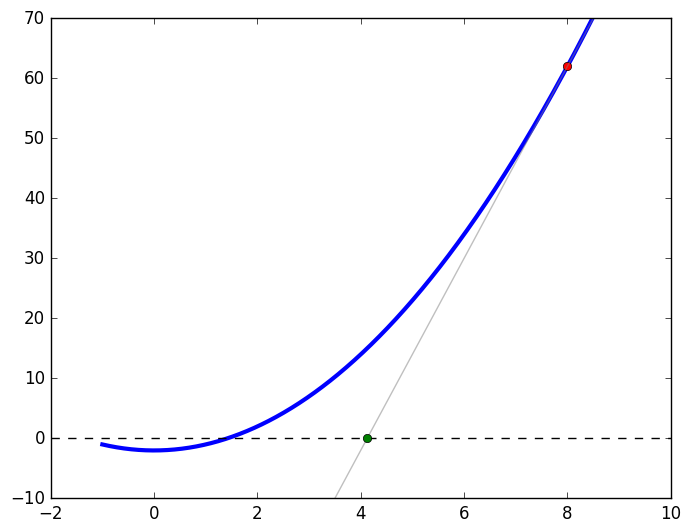

In [7]:
xx = -1:0.01:10
f(x) = x^2 - 2
x0 = 8

standard_Newton(f, xx, x0, -10, 70)

However, Newton's method can be unstable: changing the initial condition a bit can lead to complicated behaviour and a different root. (This is especially true [in the complex plane](https://en.wikipedia.org/wiki/Newton_fractal).)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

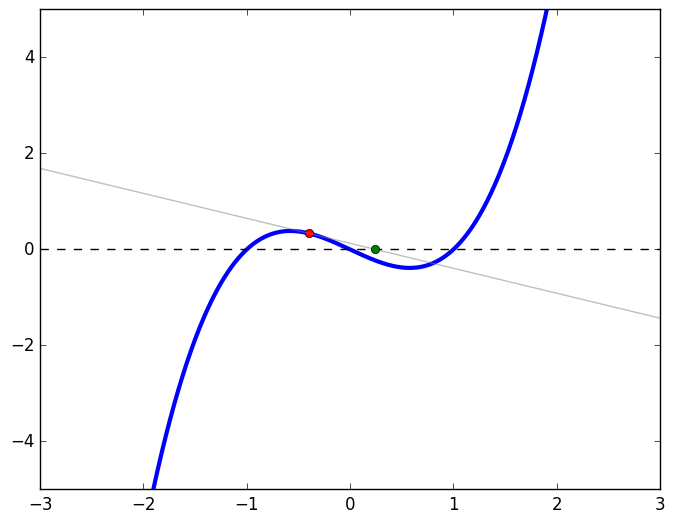

In [8]:
xx = -3:0.01:3

f(x) = x^3 - x

x0 = -0.4
standard_Newton(f, xx, x0, -5, 5)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

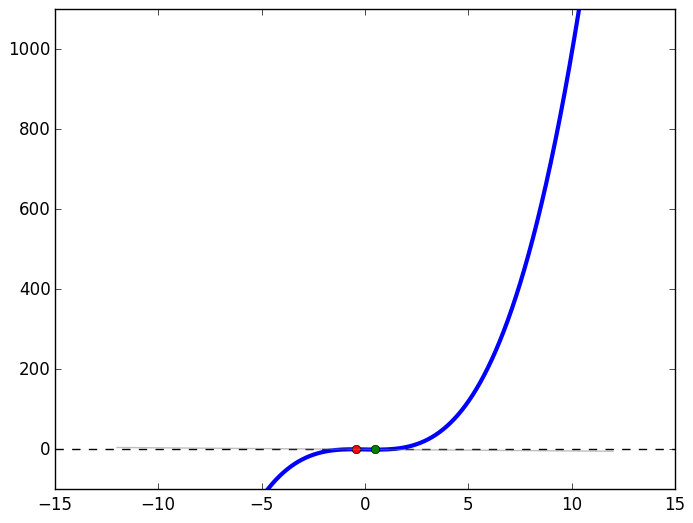

In [23]:
# Same f !
x0 = -0.45
standard_Newton(f, -12:0.01:12, x0, -100, 1100)

## A new approach: intervals

The above experiments show that the standard Newton method is badly behaved. How can we do better? 

The philosophy of *interval arithmetic* is that we should try to *enclose* the solution, i.e., find a *set* that contains the solution.

For the Newton method, we can apply the mean value theorem. This says that provided $f$ is sufficiently smooth, given $x$ and $z$, there exists $\xi \in (x,z)$ such that

$$f(z) - f(x) = f'(\xi) \cdot (z - x).$$

In particular, if there is a root $x^*$ of $f$ in a given interval $X \subseteq \mathbb{R}$, i.e. such that $f(x^*) = 0$,

then there exists a $\xi \in X$ such that

$$0 - f(x_0) = f'(\xi) \cdot (x^* - x_0).$$

In words, this means that $x^*$ is the intersection with the $x$-axis of the line at $(x_0, f(x_0))$ with *some* slope $f'(\xi)$, with $\xi$ in the original interval $X$.  Of course, finding $\xi$ is equivalent in difficulty to finding $x^*$.

## Finding an enclosure

But we can try a different approach, again following the philosophy of interval arithmetic. What if we try *all possible values* of $\xi$ in $X$? Then we are guaranteed that one of them must correspond to the root, if it is unique, or to any root, if there is more than one. 

Thus, if we find the *set* of intersections of the lines with slopes $f'(\xi)$ from the given starting point $(x_0, f(x_0))$ for all values of $\xi \in X$, we will *enclose* all of the zeros. Note that this must be true, independent of the starting point!

This is difficult to believe, so let's go back to the first example, $f(x) = x^2 - 2$. Let's try to find a root in $X = [0.5, 3]$.

We know that $f'(x) = 2x$, so that $f'(X) = [1, 6]$, where $f'(X) = \{ f'(x) : x \in X$, the image of the derivative function over the set $X$.

Let's draw *all of these lines*:

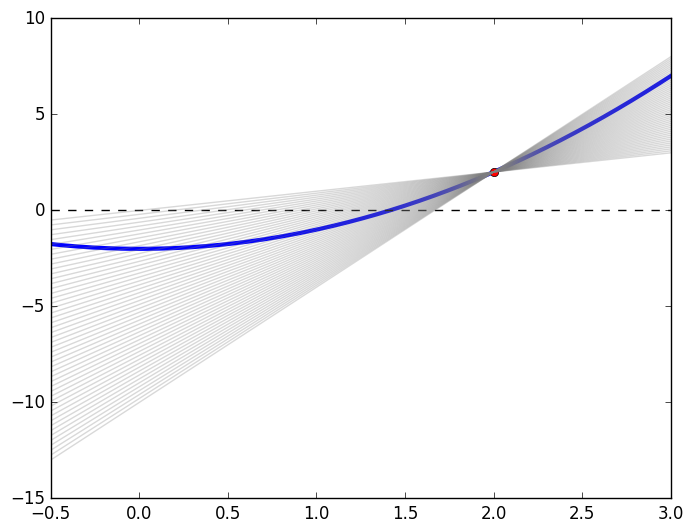

In [11]:
f(x) = x^2 - 2

xx = -0.5:0.01:3
x0 = 2.0

plot(xx, map(f, xx), lw=3)
axhline(color="black", linestyle="--")

plot([x0], [f(x0)], "ro")

for m in linspace(1, 6, 50)
    plot(xx, [straight(x0, f(x0), x, m) for x in xx], "grey", alpha=0.3)
end

We see that the result is an "interval of slopes" in the form of a cone, which intersects the $x$-axis in an *interval*. We can calculate the interval since, in this case, we know the maximum and minimum slopes. We get

$$x_\mathrm{min} = x_0 - \frac{f(x_0)}{m_\mathrm{min}}$$

and similarly for $x_\mathrm{max}$:

In [12]:
x0 = 2
xmin = x0 - f(x0) / 6
xmax = x0 - f(x0) / 1

xmin, xmax

(1.6666666666666667,0.0)

## Calculating slopes

There is one difficulty, however: in the middle of the calculation, we need the *set of possible slopes*. We were lucky in the example, in that we were able to (i) calculate the derivative at each point analytically; and (ii) calculate the maximum and minimum of the derivative over the whole interval.
|
Both of these steps are, unfortunately, usually difficult! 

Interval arithmetic comes to our rescue here, since it provides a guaranteed *bound*, or *enclosure* of sets, using simple operations. These enclosures will, in general, be too large, but they are guaranteed to contain the correct answer.

Given a function $f$, defined by a finite sequence of elementary operations, the *natural interval extension* $F$ of $f$ is obtained by applying the interval versions of the functions making up $f$ in the same order. The interval versions are guaranteed to return intervals that contain the true image of their argument.

The Julia package [`ValidatedNumerics.jl`](https://github.com/dpsanders/ValidatedNumerics.jl) provides an implementation of interval arithmetic. It can be installed with `Pkg.add("ValidatedNumerics")` and then used in a given session or notebook with the following command:

In [8]:
using ValidatedNumerics

This allows us to do calculations using `Interval` objects that represent closed and possibly unbounded intervals of the form $[a, b]$.
For example, we can create intervals using

In [9]:
X = @interval(-0.5, 3)

[-0.5, 3]

In [10]:
Y = @interval(3, ∞)

[3, ∞]

In [11]:
X + Y

[2.5, ∞]

and then evaluate the function $f$ over the interval with 

In [13]:
X + X

[-1, 6]

In [14]:
f(x) = x^2 - 2
f(X)

[-2, 7]

In [21]:
f(Y)

[7.0, ∞]

In [29]:
sin(Y)

[-1.0, 1.0]

`f` is a standard Julia function. The functions `^` and `-` have methods defined in the package to act on `Interval`s (they are "overloaded"), for example:

In [22]:
X^2

[0.0, 9.0]

In [23]:
@which X^2

^(a::ValidatedNumerics.Interval{Float64}, x::Integer) at /Users/dpsanders/.julia/v0.4/ValidatedNumerics/src/intervals/functions.jl:9

Note that in this particular case, the range is exact, but in general this will not be the case when the variable $x$ appears more than once in the expression.

We can also do set calculations using `Interval`s (which are, after all, sets):

In [34]:
X ∩ f(X)

[-2.5, -0.5]

## Evaluating the derivative over an interval

To evaluate the derivative of `f` over an interval, we leverage the excellent `ForwardDiff` package for automatic differentiation:

In [15]:
using ForwardDiff

In [18]:
f′ = x -> ForwardDiff.derivative(f, x)

(anonymous function)

In [19]:
f′(X)

[-1, 6]

In [27]:
typeof(ans)

ValidatedNumerics.Interval{Float64}

Note that the `ForwardDiff` package writers wrote their code in a generic way to work with any subtype of `Real` for which arithmetic operations are defined; they have no knowledge of the `ValidatedNumerics` package, but it just works! Once again, this will in general provide an *over-estimate* of the range of the derivative on this interval.

## Visualizing interval Newton

In [12]:
function interval_newton(f, X, ymin=-10, ymax=10)
    deriv = ForwardDiff.derivative(f, X)
    
    fig = figure()

    @manipulate for x0 in linspace(X.lo, X.hi, 50)
    
        withfig(fig) do
        
            y0 = f(x0)
            xx = X.lo:0.01:X.hi
            plot(xx, map(f, xx), "b", lw=3)
            axhline(0, color="black", linestyle="--")
            plot(x0, y0, "o")

            for m in linspace(deriv.lo, deriv.hi, 100)
                plot(xx, [ y0 + m*(x-x0) for x in xx], color="grey", alpha=0.1)
            end

            if 0 ∈ deriv
                
                N1 = x0 - f(@interval(x0)) / @interval(deriv.lo, -0.0)
                N2 = x0 - f(@interval(x0)) / @interval(0.0, deriv.hi)

                N1 = N1 ∩ X
                N2 = N2 ∩ X
                plot([N1.lo, N1.hi], [0,0], "r", linewidth=2)
                plot([N2.lo, N2.hi], [0,0], "r", linewidth=2)
                
            else
                N1 = x0 - f(@interval(x0)) / deriv
                N1 = N1 ∩ X
                
                plot([N1.lo, N1.hi], [0,0], "r", linewidth=2)
            end
            
            ylim(ymin, ymax)

                
        end
        
    end
    
end

interval_newton (generic function with 3 methods)

Interact.Slider{Float64}(Signal{Float64}(1.469387755102041, nactions=0),"x0",1.469387755102041,linspace(0.0,3.0,50),".3f",true)

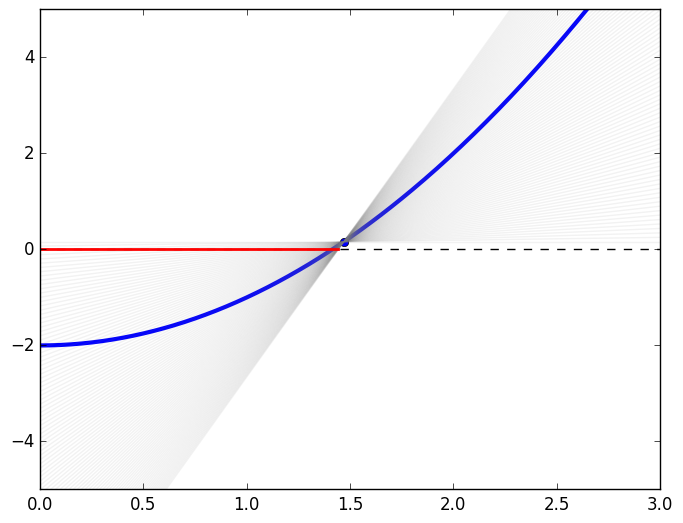

In [17]:
f(x) = x^2 - 2

X = 0..3
interval_newton(f, X, -5, 5)

What happens if the derivative contains $0$?

Interact.Slider{Float64}(Signal{Float64}(-1.5204081632653061, nactions=0),"x0",-1.5204081632653061,linspace(-2.5,-0.5,50),".3f",true)

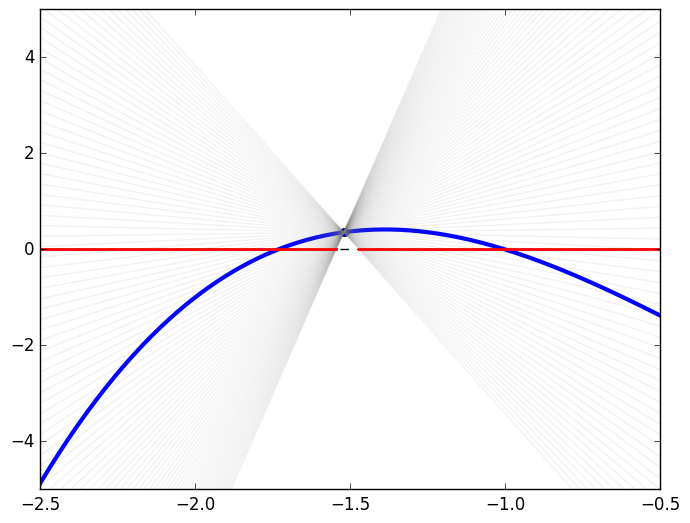

In [21]:
f(x) = x^3 + x^2 -3x - 3

X = Interval(-2.5, -0.5)
interval_newton(f, X, -5, 5)

In [10]:
X = Interval(-2.5, -0.5)
ForwardDiff.derivative(f, X)

[-7.25, 14.75]

We see that the result is naturally a *double* cone, that *separates* the possible roots of the function into two parts.

Interact.Slider{Float64}(Signal{Float64}(3.7244897959183674, nactions=0),"x0",3.7244897959183674,linspace(2.5,5.0,50),".3f",true)

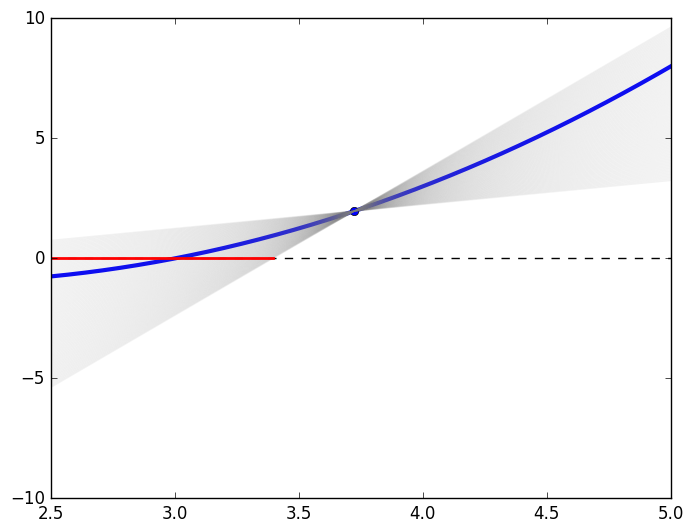

In [8]:
X = @interval(2.5, 5)
f(x) = (x-1)*(x-3)

interval_newton(f, X)

Interact.Slider{Float64}(Signal{Float64}(-0.04081632653061224, nactions=0),"x0",-0.04081632653061224,linspace(-2.0,2.0,50),true)

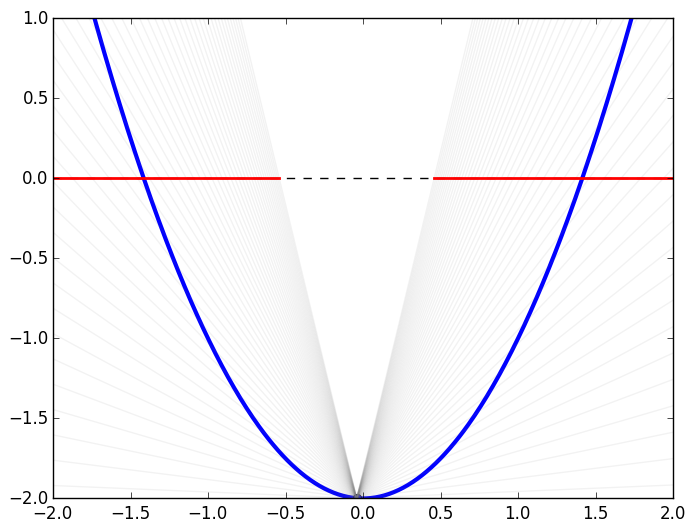

In [35]:
f(x) = x^2 - 2
X = @interval(-2, 2)

interval_newton(f, X, -2, 1)

## Visualizing the complete interval Newton algorithm

In [18]:
function interval_newton(f, X0, ymin=-10, ymax=10)
    
    fig = figure()

    @manipulate for n in collect(1:10), α in linspace(0, 1, 50)
    
        withfig(fig) do
            
            X = X0
        
            # draw graph of function over interval X
            xx = X.lo:0.01:X.hi
            plot(xx, map(f, xx), "b", lw=3)
            axhline(0, color="black", linestyle="--")
        
            
            N1 = ∅
            for i in 1:n-1
                
                x0 = (1-α)*X.lo + α*X.hi # mid(X)
                @show x0
                deriv = ForwardDiff.derivative(f, X)
            
                N1 = x0 - f(@interval(x0)) / deriv
                N1 = N1 ∩ X
                
                X = N1
            end
            
            
            if n > 1
                plot([X.lo, X.hi], [0,0], "m", linewidth=4, alpha=0.4)

                m = (1-α)*X.lo + α*X.hi
                plot([m], [0], "go")
                plot([m, m], [0, f(m)], "g--")
            end
            
            x0 = (1-α)*X.lo + α*X.hi # mid(X)
            deriv = ForwardDiff.derivative(f, X)
            
             # draw initial point
            y0 = f(x0)
            plot(x0, y0, "o")
            
            # draw cone
            for m in linspace(deriv.lo, deriv.hi, 100)
                plot(xx, [ y0 + m*(x-x0) for x in xx], color="grey", alpha=0.1)
            end

            if 0 ∈ deriv
                
                N1 = x0 - f(@interval(x0)) / @interval(deriv.lo, -0.0)
                N2 = x0 - f(@interval(x0)) / @interval(0.0, deriv.hi)

                N1 = N1 ∩ X
                N2 = N2 ∩ X
                plot([N1.lo, N1.hi], [0,0], "r", linewidth=4, alpha=0.4)
                plot([N2.lo, N2.hi], [0,0], "r", linewidth=4, alpha=0.4)
                
            else
                N1 = x0 - f(@interval(x0)) / deriv
                N1 = N1 ∩ X
                
                plot([N1.lo, N1.hi], [0,0], "r", linewidth=4, alpha=0.4)
            end
            
            ylim(ymin, ymax)

                
        end
        
    end
    
end

interval_newton (generic function with 3 methods)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(0.4897959183673469, nactions=0),"α",0.4897959183673469,linspace(0.0,1.0,50),".3f",true)

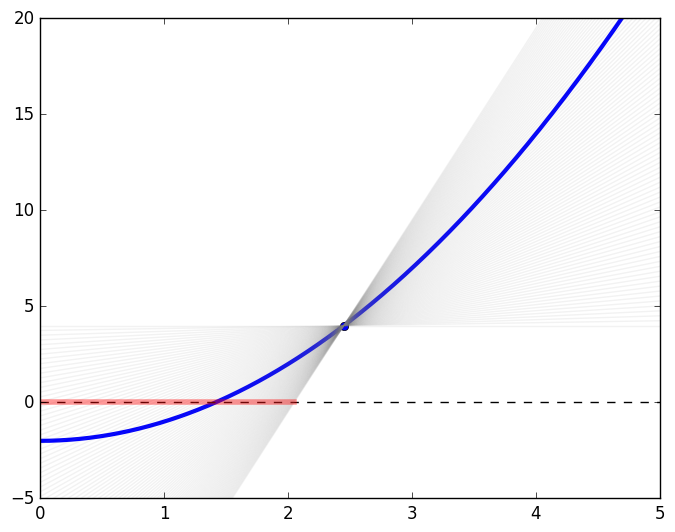

In [19]:
X = @interval(0, 5)
f(x) = x^2 - 2

interval_newton(f, X, -5, 20)

## Splitting up pairs of intervals

In [20]:
function interval_newton_full(f, X0, ymin=-10, ymax=10)
    
    fig = figure()

    @manipulate for n in collect(1:10), α in linspace(0, 1, 50)
    
        withfig(fig) do
            
            X = X0
        
            # draw graph of function over interval X
            xx = X.lo:0.001:X.hi
            plot(xx, map(f, xx), "b", lw=3)
            axhline(0, color="black", linestyle="--")
            
            Xs = [X]
            new_Xs = []
            
            N1 = ∅
            N2 = ∅
            
            for i in 1:n-1
            
                for X in Xs
                    
                    x0 = (1-α)*X.lo + α*X.hi # mid(X)
                    deriv = ForwardDiff.derivative(f, X)
                
                    if 0 ∈ deriv 
                        N1 = x0 - f(@interval(x0)) / @interval(deriv.lo, -0.0)
                        N2 = x0 - f(@interval(x0)) / @interval(0.0, deriv.hi)

                        N1 = N1 ∩ X
                        N2 = N2 ∩ X
                        
                        if !(isempty(N1))
                            push!(new_Xs, N1)
                        end
                        
                        if !(isempty(N2))
                            push!(new_Xs, N2)
                        end


                    else
                        N1 = x0 - f(@interval(x0)) / deriv
                        N1 = N1 ∩ X
                                                
                        if !(isempty(N1))
                            push!(new_Xs, N1)
                        end

                    end
                    
                end
                
                Xs = new_Xs
                new_Xs = []
                
            end
            
            for X in Xs
                if n > 1
                
                    plot([X.lo, X.hi], [0,0], "c", linewidth=4, alpha=0.3)
                    
                    m = (1-α)*X.lo + α*X.hi
                    plot([m], [0], "go")
                    plot([m, m], [0, f(m)], "g")
                end

                x0 = (1-α)*X.lo + α*X.hi # mid(X)
                deriv = ForwardDiff.derivative(f, X)

                 # draw initial point
                y0 = f(x0)
                plot(x0, y0, "bs")

                # draw cone
                for m in linspace(deriv.lo, deriv.hi, 100)
                    plot([X.lo, X.hi], [ y0 + m*(x-x0) for x in [X.lo, X.hi]], color="grey", alpha=0.1)
                end

                if 0 ∈ deriv
                    N1 = x0 - f(@interval(x0)) / @interval(deriv.lo, -0.0)
                    N2 = x0 - f(@interval(x0)) / @interval(0.0, deriv.hi)

                    N1 = N1 ∩ X
                    N2 = N2 ∩ X
                    plot([N1.lo, N1.hi], [0,0], "r", linewidth=4, alpha=0.8)
                    plot([N2.lo, N2.hi], [0,0], "r", linewidth=4, alpha=0.8)

                else
                    N1 = x0 - f(@interval(x0)) / deriv
                    N1 = N1 ∩ X

                    plot([N1.lo, N1.hi], [0,0], "r", linewidth=4, alpha=0.8)
                end
            end
            
            #text(0, 5, "$(length(Xs))")
            ylim(ymin, ymax)

                
        end
        
    end
    
end

interval_newton_full (generic function with 3 methods)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(0.4897959183673469, nactions=0),"α",0.4897959183673469,linspace(0.0,1.0,50),".3f",true)

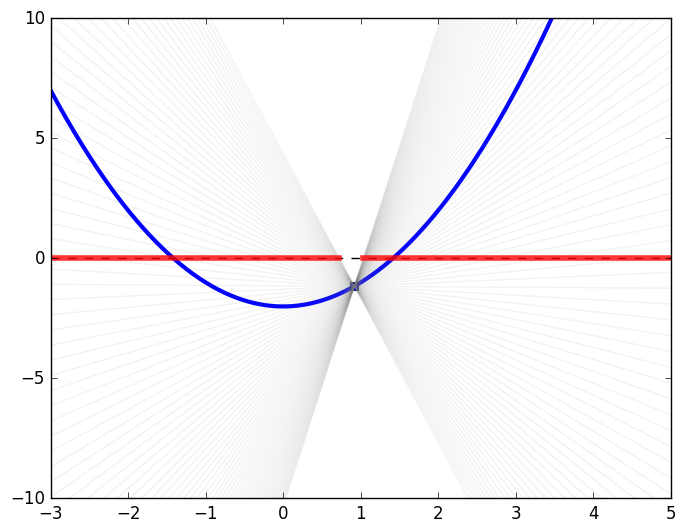

In [21]:
interval_newton_full(x->x^2 - 2, @interval(-3, 5), -10, 10)


Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(0.4897959183673469, nactions=0),"α",0.4897959183673469,linspace(0.0,1.0,50),".3f",true)

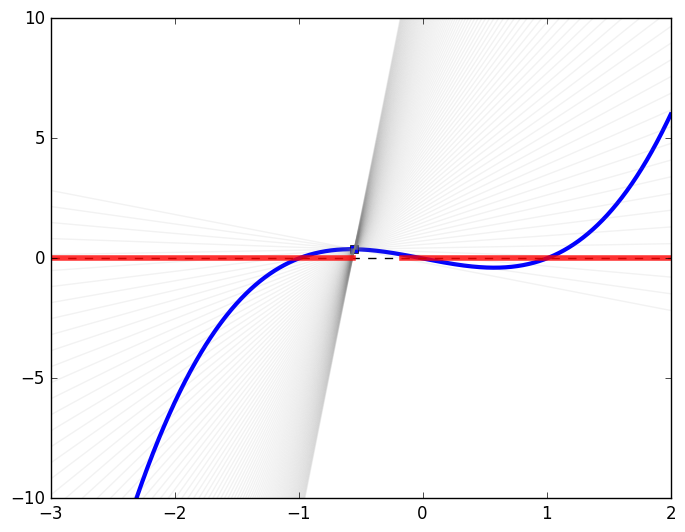

In [6]:
interval_newton_full(x->x^3 - x, @interval(-3, 2), -10, 10)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(0.4897959183673469, nactions=0),"α",0.4897959183673469,linspace(0.0,1.0,50),".3f",true)

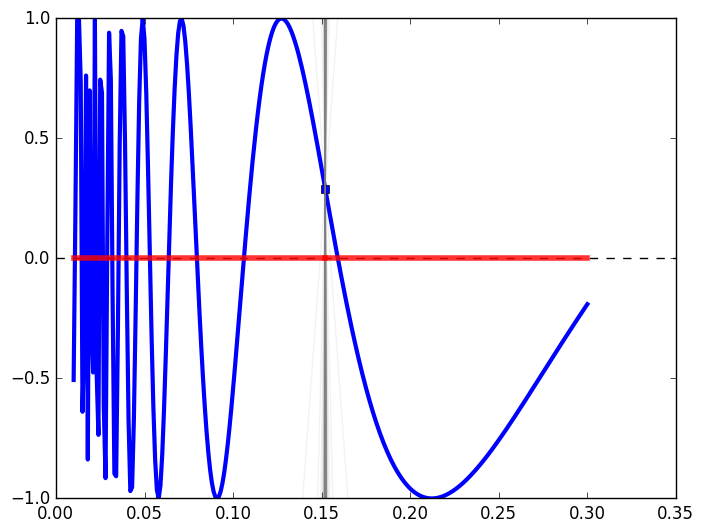

In [22]:
interval_newton_full(x->sin(1/x), @interval(0.01, 0.3), -1,1 )

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=0),"n",1,"1",Interact.OptionDict(Any["1","2","3","4","5","6","7","8","9","10"],Dict{Any,Any}("8"=>8,"4"=>4,"1"=>1,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"10"=>10,"9"=>9,"3"=>3)),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(0.4897959183673469, nactions=0),"α",0.4897959183673469,linspace(0.0,1.0,50),".3f",true)

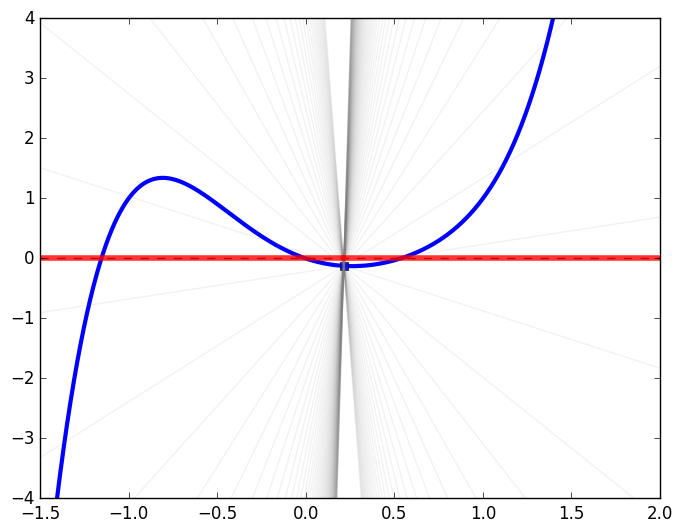

In [23]:
interval_newton_full(x->x^5 - x^4 +2x^2 - x, @interval(-1.5, 2), -4,4 )